# Preprocessing

In [18]:
import pygments.lexers
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

import sys
sys.path.append('./reentrancyContracts')
sys.path.append('./reentrancyContractLabels')
import reentrancyContracts
import reentrancyContractLabels

### Extract Global Variables

In [19]:
# takes in full contract and pull out names of global variables (with reasonable accuracy)
def getGlobalVariables(contract):
    lexer = pygments.lexers.get_lexer_by_name('Solidity')
    tokens = list(pygments.lex(contract, lexer))
    globalVarList = []
    openBracketsCount = 0
    openParenthesisCount = 0
    i = 0
    while i < len(tokens):
        if str(tokens[i][0]) == 'Token.Text.Whitespace' or str(tokens[i][0]) == 'Token.Comment.Single': None
        elif(tokens[i][1] == '{'): openBracketsCount += 1
        elif(tokens[i][1] == '}'): openBracketsCount -= 1
        elif(tokens[i][1] == '('): openParenthesisCount += 1
        elif(tokens[i][1] == ')'): openParenthesisCount -= 1
        elif(str(tokens[i][0]) == 'Token.Keyword.Type' and isType(tokens[i][1]) and openBracketsCount == 1 and openParenthesisCount == 0):
            index = 0
            potentialGlobal = ""
            include = True
            while True:
                if(tokens[i+index][1] == "constant"): 
                    include = False
                if(tokens[i+index][1] == ';'):
                    if include:
                        globalVarList.append(potentialGlobal)
                    break
                if(tokens[i+index][0] == pygments.token.Name.Variable or tokens[i+index][0] == pygments.token.Text):
                    potentialGlobal = tokens[i+index][1]
                    
                index += 1
            i += (index-1)
        i += 1
        
    return globalVarList

### Extract Modifiers

In [20]:
# extracts names of modifiers (function guards) for tokenization process
def getModifiers(contract):
    lexer = pygments.lexers.get_lexer_by_name('Solidity')
    tokens = list(pygments.lex(contract, lexer))
    filteredTokens = []
    for token in tokens:
        if str(token[0]) != 'Token.Text.Whitespace':
            filteredTokens.append(token)
            
    modifierNameList = []
    openBracketsCount = 0
    openParenthesisCount = 0
    i = 0
    while i < len(filteredTokens):
        if(str(filteredTokens[i][0]) == 'Token.Keyword.Type' and str(filteredTokens[i][1]) == 'modifier'):
            modifierNameList.append(filteredTokens[i+1][1])
        
        i += 1
        
    return modifierNameList

### Extract Function Source Code

In [21]:
# given contract source code, extracts lists of basic tokens for individual functions
def getFunctions(contract):
    lexer = pygments.lexers.get_lexer_by_name('Solidity')
    tokens = list(pygments.lex(contract, lexer))
    functionList = []
    i = 0
    while i < len(tokens):
        if str(tokens[i][0]) == "Token.Keyword.Type" and tokens[i][1] == 'function':
            currFunctionNum = len(functionList)
            functionList.append([tokens[i]])
            i += 1
            
            oneLiner = False
            while tokens[i][1] != '{':
                # the one-liner case
                if str(tokens[i][1]) == ';':
                    i += 1
                    oneLiner = True
                    break
                if str(tokens[i][0]) != 'Token.Text.Whitespace' and str(tokens[i][0]) != 'Token.Comment.Single':
                    functionList[currFunctionNum].append(tokens[i])
                i += 1
                
            functionList[currFunctionNum].append(tokens[i])
            openBracketsCount = 1
            i += 1
            
            while openBracketsCount > 0:
                if(tokens[i][1] == '{'): openBracketsCount += 1
                elif(tokens[i][1] == '}'): openBracketsCount -= 1
                
                if str(tokens[i][0]) != 'Token.Text.Whitespace' and str(tokens[i][0]) != 'Token.Comment.Single':
                    functionList[currFunctionNum].append(tokens[i])
                i += 1
        else:
            i += 1
    return functionList

### Tokenize Functions

In [22]:
# given a function's basic tokenization and a list of modifier and global variable names, fully tokenize function
def tokenize(parsedFunction, globalVariablesList, modifierNameList):
    txKeywords = ['call', 'transfer', 'send']
    tokenList = []
    for tup in parsedFunction:
        if tokenList and tokenList[-1] == "function":
            tokenList.append("Token.FunctionName")
        elif str(tup[1]) in txKeywords:
            tokenList.append("Token.TxWord")
#         elif 'Token.Literal' in str(tup[0]):
#             tokenList.append("Token.Constant")
        elif tup[1] in globalVariablesList:
            tokenList.append("Token.GlobalVariable")
        elif tup[1] in modifierNameList:
            tokenList.append("Token.ModifierName")
        elif tup[1].startswith("\""):
            tokenList.append("Token.String")
        elif str(tup[0]) == 'Token.Name.Variable' or str(tup[0]) == 'Token.Text':
            tokenList.append("Token.LocalVariable")
        elif str(tup[0]) != 'Token.Text.Whitespace' and str(tup[0]) != 'Token.Comment.Single':
            tokenList.append(tup[1])
    return tokenList

In [23]:
# checks if keyword is for variable declaration (helper for global variable parser)
def isType(word):
    keywords = ['address', 'bool', 'byte', 'bytes', 'int', 'string', 'uint', 'mapping']
    for kw in keywords:
        if kw in word:
            return True
    return False

In [24]:
# processing pipeline:
# - receives contract
# - extracts list of global variable names
# - extracts list of modifier names
# - extracts list of function source code
# - creates tokenized list of functions

def tokenizeContractFunctions(contract):
    globalVariablesList = getGlobalVariables(contract)
    modifierNameList = getModifiers(contract)
    functionList = getFunctions(contract)
    
    tokenizedFunctionList = []
    for function in functionList:
        tokenizedFunction = tokenize(function, globalVariablesList, modifierNameList)
        tokenizedFunctionList.append(tokenizedFunction)
    
    return tokenizedFunctionList

### Create DataFrame (currently not in use)

In [25]:
def createTuples(tokenizedFunctions, labels):
    tuples = []
    for i in range(len(tokenizedFunctions)):
        
        tuples.append([tokenizedFunctions[i], labels[i]])
    return tuples

In [26]:
def createDataFrame(contracts, contractLabels):
    df = pd.DataFrame(columns=['tokenized_function', 'label'])
    for i in range(len(contracts)):
        tokenizedFunctions = tokenizeContractFunctions(contracts[i])
        tuples = createTuples(tokenizedFunctions, contractLabels[i])
        appendable = pd.DataFrame(tuples, columns=['tokenized_function', 'label'])
        df = df.append(appendable, ignore_index=True)
    
    return df

### Create Matching Lists of Functions and Corresponding Labels

In [27]:
def returnData(contracts, contractLabels):
    functions = []
    labels = []
    for i in range(len(contracts)):
        tokenizedFunctions = tokenizeContractFunctions(contracts[i])
        functions.extend(tokenizedFunctions)
        labels.extend(contractLabels[i])
    
    return [functions, labels]

### Create Embeddings for Tokens

In [28]:
# creates Word2Vec mapping from token to vector
def get_w2v_mapping(tokenizedFunctionsDf, token_dim):
    w2v = Word2Vec(tokenizedFunctionsDf, min_count=1, size=token_dim, workers=3, window=3, sg=1)
    return w2v

In [29]:
# given list of tokenized functions, convert into list of list of embeddings
def vectorize_functions(tokenized_functions, w2v_mapping):
    embedding_list = []
    for i in range(len(tokenized_functions)):
        embedding = []
        for token in tokenized_functions[i]:
            embedding.append(w2v_mapping[token])
        
        embedding_list.append(embedding)
    return embedding_list

In [30]:
# given list of embeddings, add padding
def pad_embeddings(embeddings, max_length, token_dim):
    padded_embeddings = []
    for embedding in embeddings:
        zero_padding_cnt = max_length - len(embedding)
        pad = np.zeros((1, token_dim))
        for i in range(zero_padding_cnt):
            embedding = np.concatenate((embedding, pad), axis=0)
        padded_embeddings.append(embedding)
    return padded_embeddings

In [31]:
# compiles Word2Vec mapping, creates embedded function representations, and applies padding
def getFunctionEmbeddings(tokenizedFunctions, max_length, token_dim):
    w2v_mapping = get_w2v_mapping(tokenizedFunctions, token_dim)
    vectorized_fns = vectorize_functions(tokenizedFunctions, w2v_mapping)
    padded_embeddings = pad_embeddings(vectorized_fns, max_length, token_dim)
    return [w2v_mapping, padded_embeddings]

In [32]:
length = 500
token_dim = 15

[functions, labels] = returnData(reentrancyContracts.contracts, reentrancyContractLabels.labels)
[w2v_mapping, fn_embeddings] = getFunctionEmbeddings(functions, length, token_dim)
fn_embeddings = np.array(fn_embeddings)
print("X shape: ", fn_embeddings.shape)

X shape:  (227, 500, 15)


### Token Visualization

In [33]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

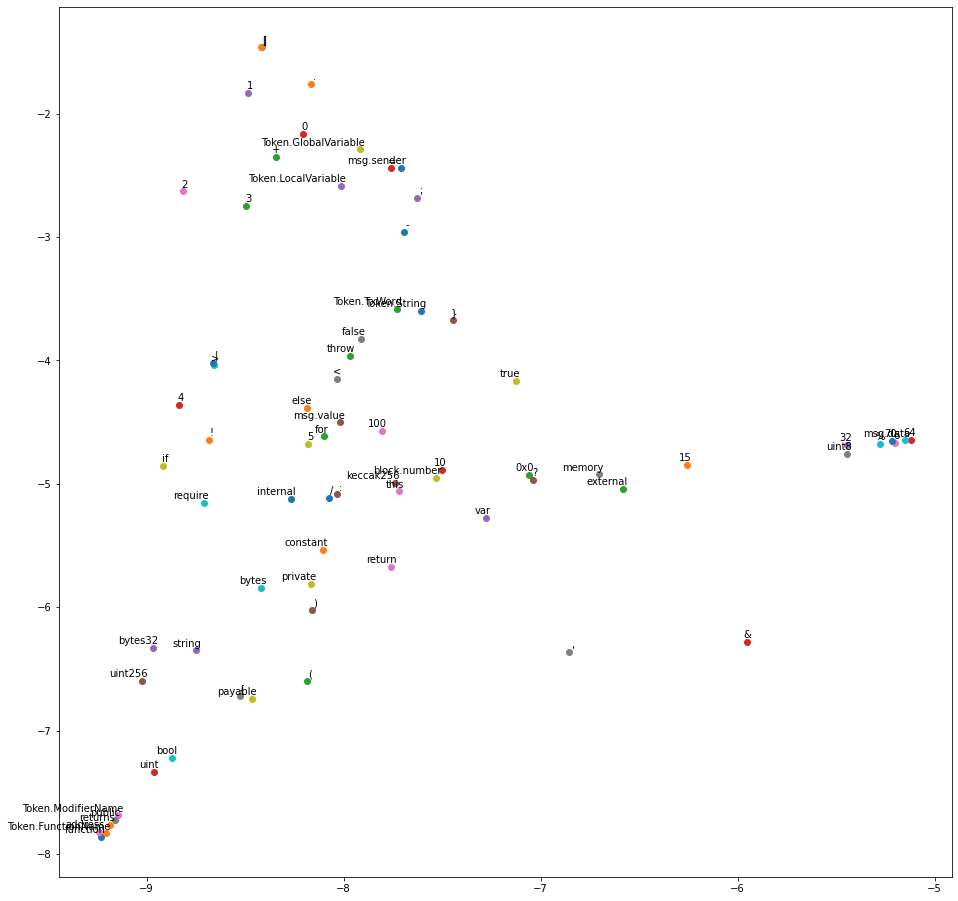

In [35]:
[functions, labels] = returnData(reentrancyContracts.contracts, reentrancyContractLabels.labels)
[w2v_mapping, fn_embeddings] = getFunctionEmbeddings(functions, length, token_dim)

tsne_plot(w2v_mapping)

In [556]:
# functions

# Models

In [495]:
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, class_weight
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, accuracy_score, f1_score, recall_score, precision_score

import tensorflow as tf
import keras.backend as K
from keras import layers, regularizers, Input
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Flatten, Embedding, Dropout, BatchNormalization
from keras.metrics import Accuracy, Precision, Recall

In [38]:
# compile formatted data and create splits
[functions, labels] = returnData(reentrancyContracts.contracts, reentrancyContractLabels.labels)
[w2v_mapping, X_train] = getFunctionEmbeddings(functions, 500, 15)

X = np.array(X_train)
y = np.array(labels)
X_train, y_train = shuffle(X[41:], y[41:])
X_test = X[:41]
y_test = y[:41]

In [40]:
print(X_train.shape)
print(y_train.shape)

(186, 500, 15)
(186,)


In [41]:
print(X_test.shape)
print(y_test.shape)

(41, 500, 15)
(41,)


In [420]:
def printResults(model, threshold):
    y_pred = model.predict(X_test)
    y_pred_eval = np.argmax(y_pred, axis=1)
    for i in range(len(y_pred)):
        val = 0
        if y_pred[i] > threshold: val = 1

        toPrint = "WRONG"
        if val == y_test[i]: toPrint = "correct"
        print(i, toPrint, ": ", val, " - ", y_pred[i][y_pred_eval[i]])

## BLSTM

In [509]:
model_1 = Sequential()
model_1.add(Bidirectional(LSTM(50)))
model_1.add(Dense(10, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

weights = class_weight.compute_class_weight('balanced', np.unique(y_test), y_train)

model_1.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("Training...")
history = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, verbose=0)

Training...


In [510]:
print("Evaluate on train data")
results = model_1.evaluate(X_train, y_train)
print("train loss, train acc:", results)

Evaluate on train data
186/186 [==============================] - 0s 1ms/step
train loss, train acc: [0.3619385467421624, 0.801075279712677]


In [511]:
print("Evaluate on test data")
results = model_1.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
41/41 [==============================] - 0s 1ms/step
test loss, test acc: [0.2907126545906067, 0.8292682766914368]


In [512]:
y_pred = model_1.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

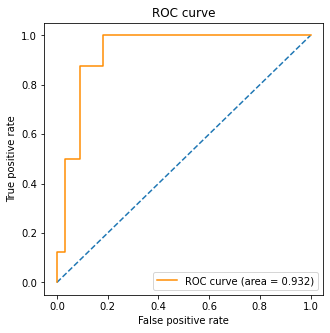

In [513]:
auc = roc_auc_score(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

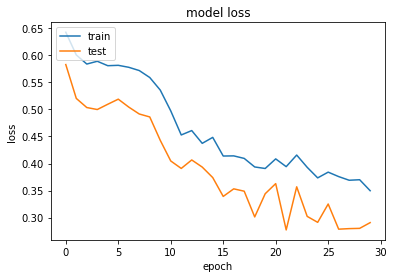

In [514]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [518]:
outputs = [1 if n >= 0.4 else 0 for n in y_pred]
print(classification_report(y_test, outputs))
print("F1 Score: ", f1_score(y_test, outputs, zero_division=1))
print("Recall Score: ", recall_score(y_test, outputs, zero_division=1))
print("Precision Score: ", precision_score(y_test, outputs, zero_division=1))
print("Accuracy Score: ", accuracy_score(y_test, outputs))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88        33
           1       0.53      1.00      0.70         8

    accuracy                           0.83        41
   macro avg       0.77      0.89      0.79        41
weighted avg       0.91      0.83      0.85        41

F1 Score:  0.6956521739130436
Recall Score:  1.0
Precision Score:  0.5333333333333333
Accuracy Score:  0.8292682926829268


In [520]:
# printResults(model_1, 0.5)

## CNN (with dropout)

In [485]:
vocab_size = len(w2v_mapping.wv.vocab)
embedding_dim = 15
embeddings_per_example = 500

metrics = [
    Precision(name='precision'),
    Recall(name='recall')
]

weights = class_weight.compute_class_weight('balanced', np.unique(y_test), y_train)

model_2 = Sequential()
model_2.add(layers.Conv1D(128, 15, activation='relu'))
model_2.add(Dropout(0.65))
model_2.add(layers.GlobalMaxPooling1D())
model_2.add(layers.Dense(10, activation='relu'))
model_2.add(Dropout(0.65))
model_2.add(layers.Dense(1, activation='sigmoid'))

model_2.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'],
                class_weights=weights)

print("Training...")
history = model_2.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=30, epochs=250, verbose=0)

Training...


In [487]:
print("Evaluate on train data")
results = model_2.evaluate(X_train, y_train)
print("train loss, train acc:", results)

Evaluate on train data
186/186 [==============================] - 0s 196us/step
train loss, train acc: [0.1264374054247333, 0.9946236610412598]


In [488]:
print("Evaluate on test data")
results = model_2.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
41/41 [==============================] - 0s 158us/step
test loss, test acc: [0.19242405891418457, 0.9268292784690857]


In [489]:
y_pred = model_2.predict(X_test)
y_pred = (y_pred > 0.4)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

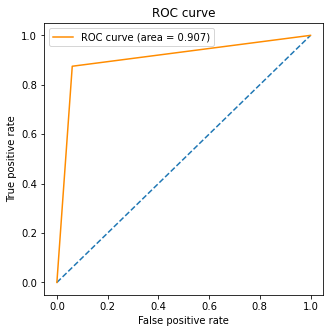

In [491]:
auc = roc_auc_score(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

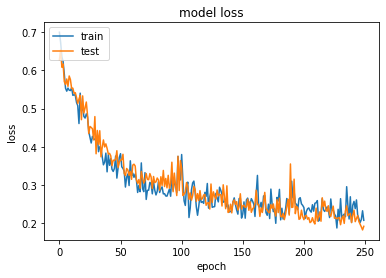

In [492]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [497]:
outputs = [1 if n >= 0.4 else 0 for n in y_pred]
print(classification_report(y_test, outputs))
print("F1 Score: ", f1_score(y_test, outputs, zero_division=1))
print("Recall Score: ", recall_score(y_test, outputs, zero_division=1))
print("Precision Score: ", precision_score(y_test, outputs, zero_division=1))
print("Accuracy Score: ", accuracy_score(y_test, outputs))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95        33
           1       0.78      0.88      0.82         8

    accuracy                           0.93        41
   macro avg       0.87      0.91      0.89        41
weighted avg       0.93      0.93      0.93        41

F1 Score:  0.823529411764706
Recall Score:  0.875
Precision Score:  0.7777777777777778
Accuracy Score:  0.926829268292683


In [506]:
# printResults(model_2, 0.4)

## CNN (L2 regularization)

In [521]:
vocab_size = len(w2v_mapping.wv.vocab)
embedding_dim = 15
embeddings_per_example = 500

metrics = [
    Precision(name='precision'),
    Recall(name='recall')
]

weights = class_weight.compute_class_weight('balanced', np.unique(y_test), y_train)

model_3 = Sequential()
model_3.add(layers.Conv1D(128, 15, activation='relu'))
model_3.add(layers.GlobalMaxPooling1D())
model_3.add(layers.Dense(10, activation='relu', activity_regularizer=regularizers.l2(0.01)))
model_3.add(layers.Dense(1, activation='sigmoid', activity_regularizer=regularizers.l2(0.01)))

model_3.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'],
                class_weights=weights)

print("Training...")
history = model_3.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=30, epochs=250, verbose=0)

Training...


In [522]:
print("Evaluate on train data")
results = model_3.evaluate(X_train, y_train)
print("train loss, train acc:", results)

Evaluate on train data
186/186 [==============================] - 0s 247us/step
train loss, train acc: [0.3743925956628656, 1.0]


In [523]:
print("Evaluate on test data")
results = model_3.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
41/41 [==============================] - 0s 263us/step
test loss, test acc: [0.47069257497787476, 0.9268292784690857]


In [524]:
y_pred = model_3.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

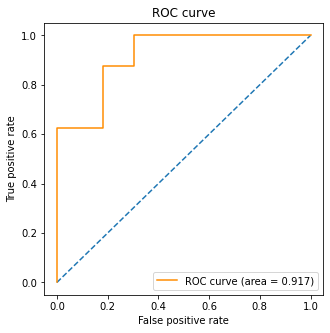

In [525]:
auc = roc_auc_score(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

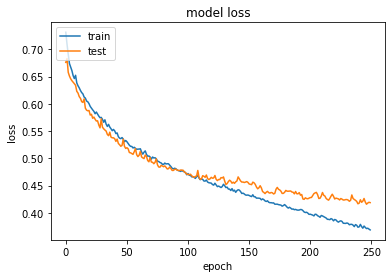

In [526]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [527]:
outputs = [1 if n >= 0.4 else 0 for n in y_pred]
print(classification_report(y_test, outputs))
print("F1 Score: ", f1_score(y_test, outputs, zero_division=1))
print("Recall Score: ", recall_score(y_test, outputs, zero_division=1))
print("Precision Score: ", precision_score(y_test, outputs, zero_division=1))
print("Accuracy Score: ", accuracy_score(y_test, outputs))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        33
           1       1.00      0.62      0.77         8

    accuracy                           0.93        41
   macro avg       0.96      0.81      0.86        41
weighted avg       0.93      0.93      0.92        41

F1 Score:  0.7692307692307693
Recall Score:  0.625
Precision Score:  1.0
Accuracy Score:  0.926829268292683


In [530]:
# printResults(model_2, 0.4)

## CNN (Added Conv1D Layer)

In [535]:
vocab_size = len(w2v_mapping.wv.vocab)
embedding_dim = 15
embeddings_per_example = 500

metrics = [
    Precision(name='precision'),
    Recall(name='recall')
]

weights = class_weight.compute_class_weight('balanced', np.unique(y_test), y_train)

model_4 = Sequential()
model_4.add(layers.Conv1D(128, 10, activation='relu'))
model_4.add(layers.Conv1D(64, 10, activation='relu'))
model_4.add(layers.GlobalMaxPooling1D())
model_4.add(layers.Dense(10, activation='relu'))
model_4.add(layers.Dense(1, activation='sigmoid'))

model_4.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'],
                class_weights=weights)

print("Training...")
history = model_4.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=30, epochs=150, verbose=0)

Training...


In [536]:
print("Evaluate on train data")
results = model_4.evaluate(X_train, y_train)
print("train loss, train acc:", results)

Evaluate on train data
186/186 [==============================] - 0s 414us/step
train loss, train acc: [0.0005448332565876666, 1.0]


In [537]:
print("Evaluate on test data")
results = model_4.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
41/41 [==============================] - 0s 611us/step
test loss, test acc: [0.3498380780220032, 0.8536585569381714]


In [538]:
y_pred = model_4.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

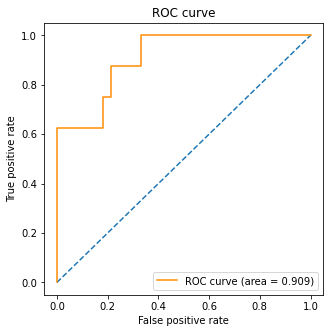

In [544]:
auc = roc_auc_score(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

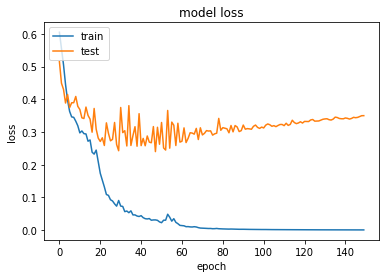

In [545]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [540]:
outputs = [1 if n >= 0.4 else 0 for n in y_pred]
print(classification_report(y_test, outputs))
print("F1 Score: ", f1_score(y_test, outputs, zero_division=1))
print("Recall Score: ", recall_score(y_test, outputs, zero_division=1))
print("Precision Score: ", precision_score(y_test, outputs, zero_division=1))
print("Accuracy Score: ", accuracy_score(y_test, outputs))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89        33
           1       0.56      0.62      0.59         8

    accuracy                           0.83        41
   macro avg       0.73      0.75      0.74        41
weighted avg       0.84      0.83      0.83        41

F1 Score:  0.5882352941176471
Recall Score:  0.625
Precision Score:  0.5555555555555556
Accuracy Score:  0.8292682926829268


In [543]:
# printResults(model_4, 0.4)

## CNN (higher positive class weight)

In [546]:
vocab_size = len(w2v_mapping.wv.vocab)
embedding_dim = 15
embeddings_per_example = 500

metrics = [
    Precision(name='precision'),
    Recall(name='recall')
]

weights = [.65, 2.5]

model_5 = Sequential()
model_5.add(layers.Conv1D(128, 15, activation='relu'))
model_5.add(layers.GlobalMaxPooling1D())
model_5.add(layers.Dense(10, activation='relu'))
model_5.add(layers.Dense(1, activation='sigmoid'))

model_5.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'],
                class_weights=weights)

print("Training...")
history = model_5.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=30, epochs=300, verbose=0)

Training...


In [547]:
weights

[0.65, 2.5]

In [548]:
print("Evaluate on train data")
results = model_5.evaluate(X_train, y_train)
print("train loss, train acc:", results)

Evaluate on train data
186/186 [==============================] - 0s 232us/step
train loss, train acc: [0.060842230515454405, 1.0]


In [549]:
print("Evaluate on test data")
results = model_5.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
41/41 [==============================] - 0s 190us/step
test loss, test acc: [0.2678564488887787, 0.9268292784690857]


In [550]:
y_pred = model_5.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

In [551]:
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)

AUC: 0.970


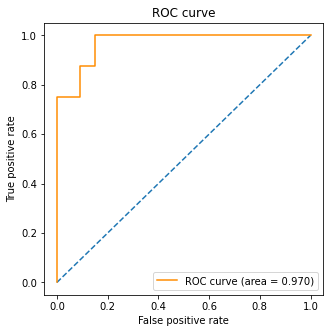

In [552]:
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

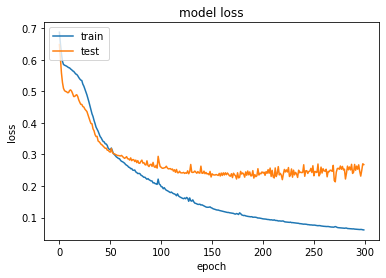

In [553]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [554]:
outputs = [1 if n >= 0.4 else 0 for n in y_pred]
print(classification_report(y_test, outputs))
print("F1 Score: ", f1_score(y_test, outputs, zero_division=1))
print("Recall Score: ", recall_score(y_test, outputs, zero_division=1))
print("Precision Score: ", precision_score(y_test, outputs, zero_division=1))
print("Accuracy Score: ", accuracy_score(y_test, outputs))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        33
           1       1.00      0.62      0.77         8

    accuracy                           0.93        41
   macro avg       0.96      0.81      0.86        41
weighted avg       0.93      0.93      0.92        41

F1 Score:  0.7692307692307693
Recall Score:  0.625
Precision Score:  1.0
Accuracy Score:  0.926829268292683


In [557]:
# printResults(model_5, 0.4)